# Iterative Prisoner's Dilemma


### Description

The [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) (PD) is a classical game analyzed in game theory, which is widely used to (attempt to) model social/economical interaction. It's a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance.

The classical situation-representation of the PD is that of two prisoners whose conviction depends on their mutual cooperation. It is easier understood though if illustrated in terms of a trade-off game (closed bag exachange):

*Two people meet and exchange closed bags, with the understanding that one of them contains money, and the other contains a purchase. Either player can choose to honor the deal by putting into his or her bag what he or she agreed, or he or she can defect by handing over an empty bag.*

It is obvious that for both players the winning strategy is to NOT cooperate.

Things changes when the interaction between the two individuals is iterated, in that case a more altruist attitude (strategy) is expected to emerge. The goal of this project is to test this hypothesis.

Mathematically the PD can be expressed with very basic linear algebra. The key component is the **Payoff matrix** $M$, which quantify the reward each player gets depending on whether she cooperated or not (defect):

$$
M = 
\begin{pmatrix} 
R & S \\
T & P 
\end{pmatrix}
$$

with $T,R,S,P$ integers that satisfy the following conditions:

$$
T>R>P>S; \quad 2R > T+S
$$

for example $T=3$, $R=2$, $P=1$ and $S=0$, or  $T=5$, $R=3$, $P=2$, $S=0$. Each player choice (move) can be represented by one of the two axis in ${\rm I\!R}^2$, i.e. $u_C=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ or $u_D=\begin{pmatrix} 0 \\ 1 \end{pmatrix}$, where the first coordinate stands for *Cooperate* and the second for *Defect*. Being $u_1$ and $u_2$ their rewards $r_1$ and $r_2$ can be computed then as:

$$
r_1 = u_1^T M u_2
\quad
\quad
r_2 = u_2^T M u_1
$$

In an Iterative Prisoner's Dilemma (IPD), two players play prisoner's dilemma more than once in succession and they remember previous actions of their opponent and change their strategy accordingly. The winning strategy is the one which yields to a larger reward at the end of the IPD.

The strategy can be represented as a function which outputs either $u_C$ or $u_D$. Such function can depend on the opponent's history of moves, her on history of moves, on the number of moves played till that moment and so on, but it can only be based on a probability density function. Possible strategies are:

* **Nice guy**: always cooperate (the function's output is always $u_D$)
* **Bad guy**: always defect 
* **Mainly nice**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k<50$
* **Mainly bad**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k>50$
* **tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move 

Many more and much more complex strategies can be implemented. The strategy can even change during the IPD.


### Assignments

* Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations. 
* Implement a multiple players IPD (MPIPD) where several strategies play against each other in a roud-robin scheme
* Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration
* (*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.  


## Basic elements and 1-on-1 matches

In [1]:
import numpy as np
from numpy.random import random
import pandas as pd
import matplotlib.pyplot as plt

We start by defining a `Player` class.

In [2]:
class Player:
    def __init__(self, k):
        self.k = k
    
    def play(self, hist):
        return random() < self.k
 
# special child class for tit-for-tat strategies (see later)
class TftPlayer(Player):
    def play(self, hist):
        return hist[-1]

'class Player:\n    def __init__(self, k):\n        self.k = k\n    \n    def play(self, hist):\n        return random() < self.k\n \n# special child class for tit-for-tat strategies (see later)\nclass TftPlayer(Player):\n    def play(self, hist):\n        return hist[-1]'

Then a function that implements the basic 1-on-1 game mechanics. The default payoff matrix will be
$$
    M = \begin{pmatrix} 2 & 0 \\ 3 & 1 \end{pmatrix},
$$
corresponding to
$$
    R = 2,\, S = 0,\, T = 3,\, P = 1.
$$
If both players cooperate, they both receive 2 points (**R**eward). If they betray each other, they each receive 1 point (**P**unishment). If one player betrays their cooperative opponent, the betrayer receives 3 points (**T**emptation payoff) while the betrayed player gets 0 (**S**ucker’s payoff).

In [3]:
def game(pl1, pl2, it, payoff=(3, 2, 1, 0)):
    hist1 = [True] # only for the correct init of tit-for-tat
    hist2 = [True] # same
    points = [0, 0]
    
    for i in range(it):
        res1 = pl1.play(hist2)
        res2 = pl2.play(hist1)
        hist1.append(res1)
        hist2.append(res2)
        if res1 and res2:
            points[0] += payoff[1]
            points[1] += payoff[1]
        elif res1 and not res2:
            points[1] += payoff[0]
            points[0] += payoff[3]
        elif not res1 and res2:
            points[1] += payoff[3]
            points[0] += payoff[0]
        else:
            points[0] += payoff[2]
            points[1] += payoff[2]
 
    return points

Then, we define the following basic strategies:
* _nice player_, a player who always cooperates;
* _evil player_, a player who always betrays.

And the intermediate versions:
* _average player_, a player who cooperates half the time;
* _mostly nice player_, a player with a cooperation probability of 0.75;
* _mostly bad player_, a player with a cooperation probability of 0.25.

Also, we’ll implement a basic example of a different kind of strategy, commonly referred to as “tit-for-tat”. A tit-for-tat player starts by cooperating on the first iteration and then copies their opponent’s previous move from that point forward.

In [4]:
from basic_strategies import *
from additional_strategies import *

def init_classed(N):
    pl=[]
    for i in range(N//17):
        pl.append(Player(0,0))
        pl.append(Player(0.25,0))
        pl.append(Player(0.5,0))
        pl.append(Player(0.75,0))
        pl.append(Player(1,0))
        
        pl.append(Player(0.5,1))
        pl.append(Player(0.5,-1))
        
        pl.append(SusTFT())
        pl.append(Spiteful())
        pl.append(Periodic(True, False))
        pl.append(Periodic(True, True, False))
        pl.append(Periodic(True, False, False))
        pl.append(TF2T())
        pl.append(Majority(True))
        pl.append(Majority(False))
        pl.append(HTFT())
        
        pl.append(Responsive(0.5,0.5))
        
        return pl

Let’s examine some 1-on-1 matchups of these strategies.

The result of a nice versus evil match is easily predicted: Nice will always receive the sucker’s payoff, while Evil will receive a temptation reward in every iteration, resulting in a score of T times the number of iterations to zero in favour of the betrayer.

If the number of iterations is large enough, matchups between mostly nice/evil players are also predictable. For example, in the Evil versus Average matchup, the score ratio will converge to 4 in favour of Evil.
This is because half the time both players will receive $P = 1$ points (reciprocal betrayal), while in the other instances Evil will receive $T=3$ points and Average will receive $S = 0$. So, if $E$ is Evil’s score and $A$ is Average’s,
$$
    \frac{E}{A} \approx \frac{P / 2 + T / 2}{P / 2 + S / 2} = 4.
$$
Indeed:

In [5]:
iters = 1000
evil_v_avg = game(evil_pl, avg_pl, iters)
print(f"Evil v Average:\n {evil_v_avg}")
print(f"Score ratio: {evil_v_avg[0]} / {evil_v_avg[1]} \
= {evil_v_avg[0] / evil_v_avg[1]}")

NameError: name 'evil_pl' is not defined

Betrayal usually prevails, as seen in the classic dilemma. The situation becomes more intriguing when a tit-for-tat player is introduced. Let's observe how they fare with the reigning champion.

In [ ]:
tt_v_evil = game(tt_pl, evil_pl, iters)
print(f"Tit-for-tat v Evil:\n {tt_v_evil}")

Evil wins by three points. The first move is crucial: Tit-for-tat cooperates initially and hence loses three points to Evil. From that point on, they engage in reciprocal betrayal in every turn, resulting in each player earning one point. With our 1000 iterations, the final score becomes 999 to 1002.

Then, what happens to the other players? To get the full picture, we’ll play a small tournament among these six players and look at the averaged scores at the end.

In [9]:
def tournament(players, iters):
    N = len(players)
    results = np.zeros((N, N))
    for i in range(N):
            # start from i to allow players to compete against themselves
        for j in range(i, N):
            score = game(players[i], players[j], iters)
                # results[i, j] is the sum of all points made
                # by player i when playing j
            results[i, j] += score[0]
            if i == j:
                continue # avoid double counting
            results[j, i] += score[1]

    # return average points per iteration
    return results / (iters)

players = init_classed(17)
player_names = [pl.__name__() for pl in players]

results = tournament(players, 1000)
results = pd.DataFrame(results,
                          index=player_names,
                          columns=player_names)



<AxesSubplot: >

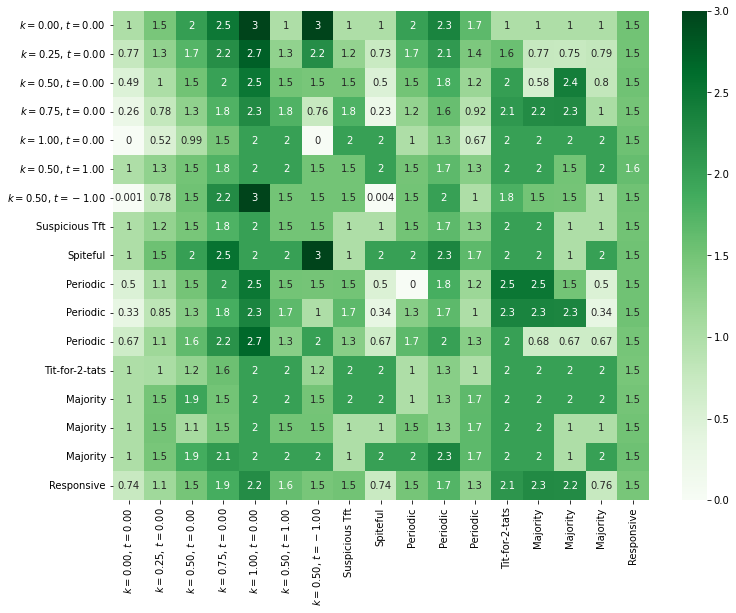

In [10]:
import seaborn as sn
plt.figure(figsize=(12, 9))
sn.heatmap(results, annot=True, cmap="Greens")

The entries in the tournament matrix indicate the average score achieved by the player associated with the corresponding row, across all rounds, against the player represented by the column.

Thus, by taking the average along the rows, we can determine which
player performs the best, on average.

In [ ]:
standings = tournament.mean(axis=1).sort_values(ascending=False)
standings

The evil players win, once again!

However, if we look the average score obtained by each player *against themselves*, we get this:

In [ ]:
standings_self = pd.Series(np.diag(tournament),
                           index=player_names).sort_values(ascending=False)
standings_self

So, Evil players do well against other types of players, but their
individualistic strategy leads to suboptimal outcomes for the population
as a whole. A completely Evil population will result in the least favourable
distribution of rewards.

On the other end of the spectrum are Nice and Tit-for-tat players.
Out of these two, as we’ve seen above, Tit-for-tat has a better performance
across the board. If we were to look at it from a “Survival of the Fittest”
perspective, we’d expect Tit-for-tat – or some variant of it – to
become the dominant strategy. This is what we’ll investigate in the next
section.

## Battle Royal

In this section we’ll implement an “evolutionary” round-robin tournament:
we’ll keep a fixed total population of players throughout the tournament,
but the number of players in each class will change proportionally to the 
scores in the previous round. The following function `init_classed` sets
up the initial population of players. We’ll start with a uniform 
distribution of the six strategies we discussed in the previous section.

In [ ]:
def init_classed(num_players):
    return np.array([Player(1), Player(0.75), Player(0.5), Player(0.25),
                     Player(0), TftPlayer(-1)] * (num_players // 6)
                    # fill remaining spots with Average players
                    + [Player(0.5)] * (num_players % 6))

The next function, `repeated`, performs a run of a given number of cycles 
and stops it if the scores remain unchanged for 20 consecutive cycles, with
a tolerance of 0.001%. The function `select` is used to sort the results
and adjust the distribution of the population according to the following 
rule:
$$
    C_i^{(n + 1)} = C_i^{(n)} \biggl(1 + \frac{S_i^{(n)} - \mu_{\vphantom{i}}^{(n)}}{\mu^{(n)}}\biggr),
$$
where $C_i^{(n)}$ is the number of players in the class (strategy) $i$ at the $n$-th
cycle, $S_i^{(n)}$ the score of the $i$-th class, and
$$
    \mu^{(n)} = \frac{1}{N_\mathrm{p}} \sum_{i = 1}^{N_\mathrm{c}}
    C_i^{(n)} S_i^{(n)}
$$
with $N_\mathrm{c}$ the number of classes and $N_\mathrm{p}$ the total number of players. Here is a simple proof that the total population doesn’t change using this update rule:
$$
    \sum_{i=1}^{N_\mathrm{c}} C_{i}^{(n + 1)} = \sum_{i = 1}^{N_\mathrm{c}} {}\Biggl[C_i^{(n)} + 
    \frac{C_i^{(n)}}{\mu^{(n)}} \Biggl(S_i^{(n)} - \frac{1}{N_\mathrm{p}} \sum_{j = 1}^{N_\mathrm{c}} C_j^{(n)} S_j^{(n)} \Biggr)\Biggr],
$$
and since $C_i^{(n)} = N_\mathrm{p}$,
$$
    \sum_{i = 1}^{N_\mathrm{c}} C_{i}^{(n + 1)} 
    = N_\mathrm{p} + 
        \frac{1}{\mu^{(n)}} \sum_{i=1}^{N_\mathrm{c}} C_i^{(n)} S_i^{(n)} 
        - \frac{N_\mathrm{p}}{\mu^{(n)}} \sum_{j = 1}^{N_\mathrm{c}} \frac{C_{j}^{(n)} S_j^{(n)}}{N_\mathrm{p}} = N_\mathrm{p}.
$$

So, the strategies with higher scores will reproduce more, while the population with below-average performance will decrease as the tournament progresses

In [ ]:
def repeated(num_players, iters, cycles):
    players = init_classed(num_players)

    # call round_robin with 10 games per matchup
    num_games = 10
    scores = round_robin(players, iters, num_games)
    results = [(players, scores)]

    stop_counter = 0
    for i in range(cycles - 1):
        players = select(players, scores)
        scores = round_robin(players, iters, num_games)
        results.append((players, scores))

        if (np.allclose(scores, results[i][1],
                        atol=0.0001 * max(scores))):
            stop_counter += 1
        else:
            stop_counter = 0
        
        if stop_counter == 20:
            break

    players = select(players, scores)

    return results

def select(players, scores, notquite=True):
    num_players = len(players)

    # define types as set so we get unique values
    types = {(p.__class__, p.init_values()) for p in players}
    #for p in players:
    #    player_type = (p.__class__, p.init_values())
    #    for t in types:
    #        if t == player_type:
    #            break
    #    else:
    #        types.append(player_type)

    # add scores by types
    sc_by_type = np.empty(len(types))
    num_by_type = np.empty(len(types))
    for idx_t, t in enumerate(types):
        t_score = [scores[i] for i in range(num_players)
                             if t == (players[i].__class__, 
                                      players[i].init_values())]
        
        sc_by_type[idx_t] = np.mean(t_score)
        num_by_type[idx_t] = len(t_score)

    if notquite:
        return types, sc_by_type, num_by_type

    glob = sorted([(types[i], sc_by_type[i]) for i in range(len(types))],
                  key=lambda x: x[1], reverse=True)
    
    mu = np.sum(num_by_type * sc_by_type) / num_players
    new_nums = (num_by_type * (1 + (sc_by_type - mu) / mu)).astype(int)

    new_players = [t[0](*t[1]) for i in new_nums[idx_t]
                               for idx_t, t in enumerate(types)]
    while len(new_players) < num_players:
        new_players.append(types[0][0](*types[0][1]))

    return new_players

Then, the function `stats` computes the mean and standard deviation of the scores for each strategy over the last 20 cycles, where a stable solution should have been reached. Additionally, it generates two plots to display the trend of both the count and score of each strategy.

In [ ]:
def stats(results):
    scores = []
    counts = []
    strat, sc, nums = select(*results[0], True)
    names = [str(s) for s in strat]

    scores.append(sc)
    counts.append(nums)

    for res in results[1:]:
        strat, sc, nums = select(*res, True)
        new_names = [str(s) for s in strat]

        sc_ord = []
        num_ord = []
        for i in range(len(names)):
            for j in range(len(new_names)):
                if new_names[j] == names[i]:
                    sc_ord.append(sc[j])
                    num_ord.append(nums[j])
            else:
                sc_ord.append(0)
                num_ord.append(0)

        scores.append(sc_ord)
        counts.append(num_ord)

    scores = np.array(scores).T
    counts = np.array(counts).T

    means = []
    dev = []

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    for n in range(len(names)):
        means.append(np.mean(scores[j][-20:]))
        dev.append(np.std(scores[j][-20:]))
        ax[0].plot(np.arange(0, len(results)),
                   scores[j], label=names[j])
        ax[1].plot(np.arange(0, len(results)),
                   counts[j], label=names[j])
        ax[0].legend()

    return strat, means, dev

In [ ]:
N = 120
it = 100
cyc = 100

hist = repeated(N, it, cyc)